## Importing Modules

In [0]:
from scipy import misc
import numpy as np
import os
import seaborn as sns
import  matplotlib.image as mpimg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading Dataset

In [0]:
# convert image to sole vector
def img2vector(filename):
    imgVector = mpimg.imread(filename).flatten()
    return imgVector.astype(np.float)

# load image from diretion
def loadimage(dataSetDir):
    X = np.zeros((400, 10305))  # image size:112*92
    k = 0
    for i in range(1,41): #40 sample people
            for j in range(1,11): #everyone has 10 different face
                    filename = dataSetDir+'/s'+str(i)+'/'+str(j)+'.pgm'
                    img = img2vector(filename)
                    X[k,:10304] = img
                    X[k,10304] = i
                    k=k+1                    
    return X

In [0]:
# import tarfile
# tf = tarfile.open("att_faces.tar.Z")
# tf.extractall()
!unzip "att_Faces.zip"

In [74]:
X = loadimage(os.getcwd()+'/att_Faces/orl_faces')
y = X[:,10304]
X = X[:,:10304]
print(X.shape)
print(y.shape)

(400, 10304)
(400,)


### Plotting samples

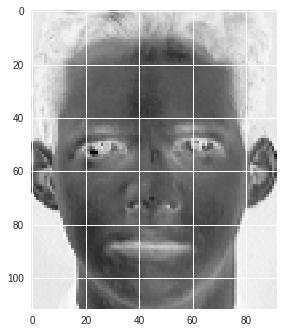

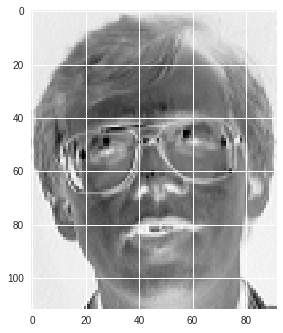

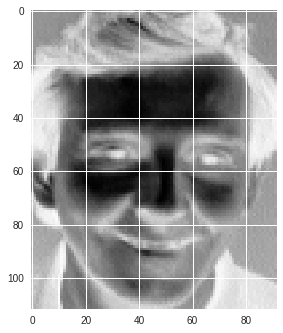

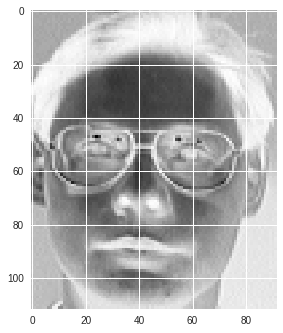

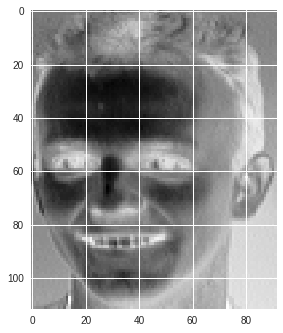

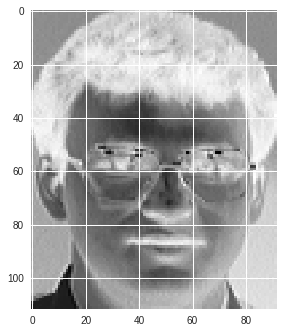

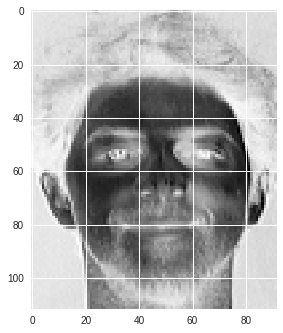

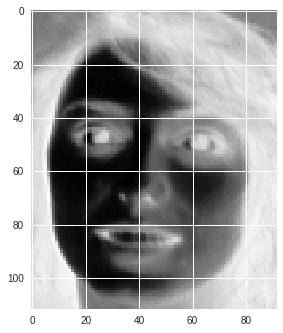

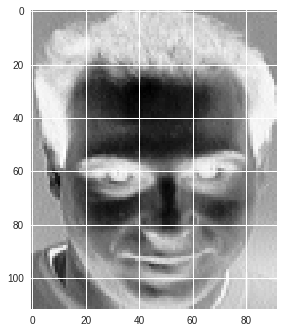

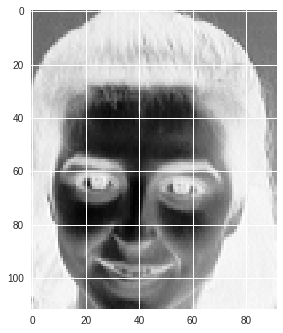

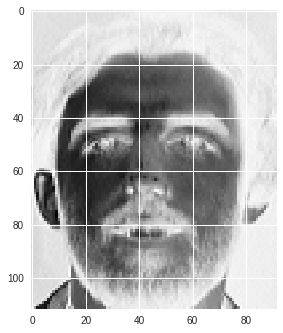

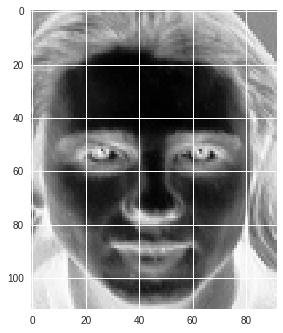

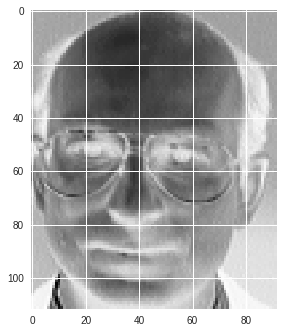

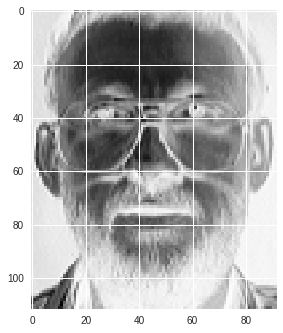

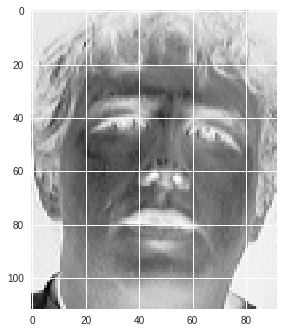

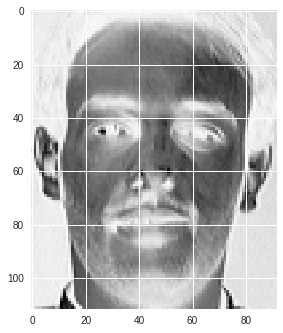

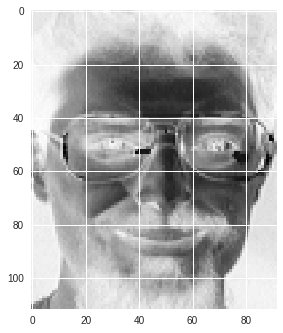

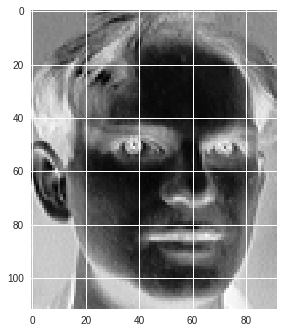

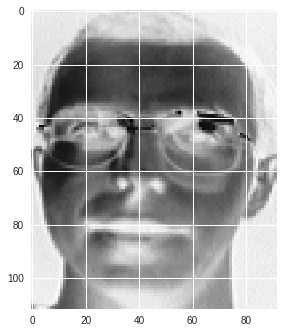

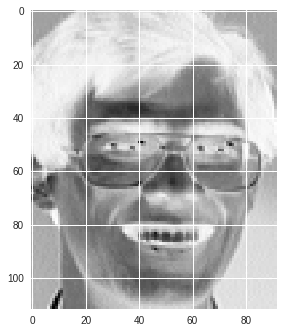

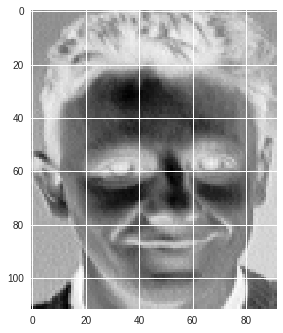

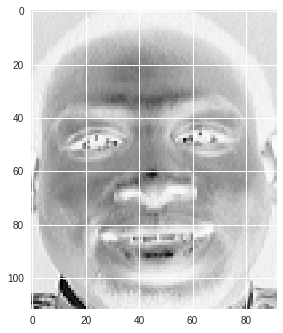

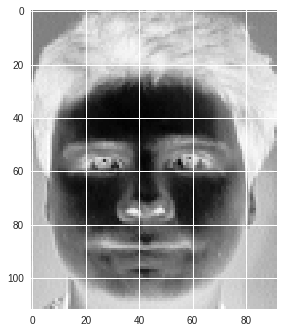

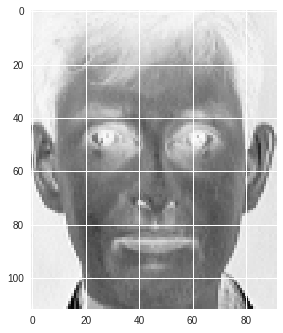

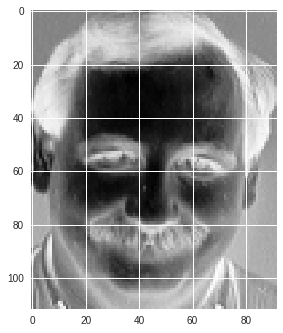

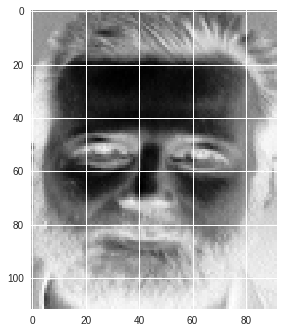

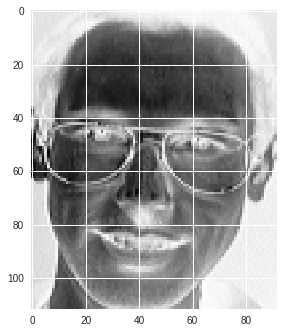

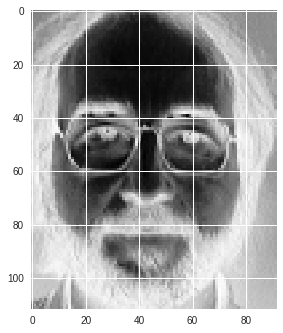

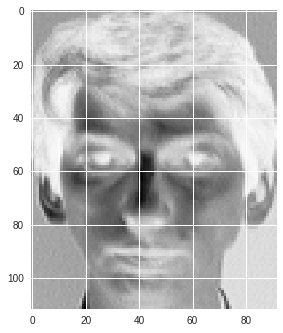

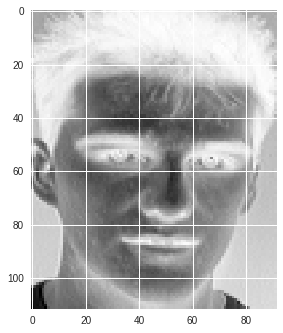

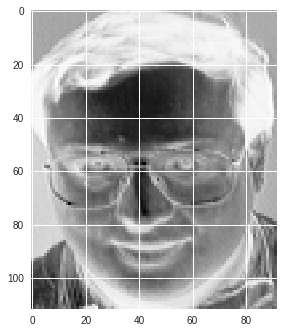

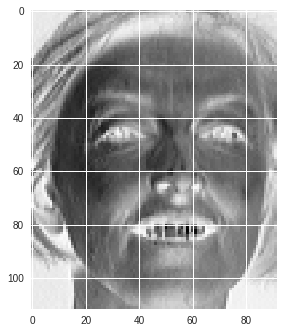

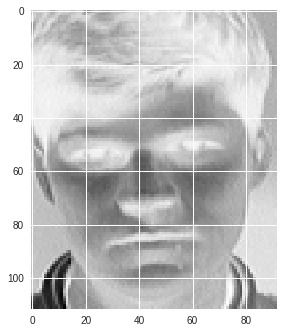

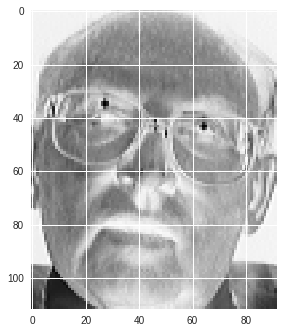

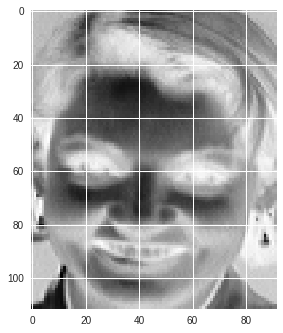

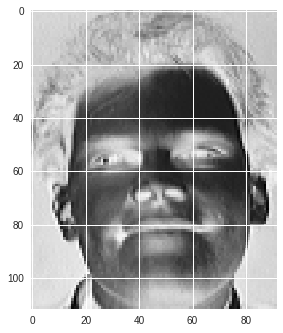

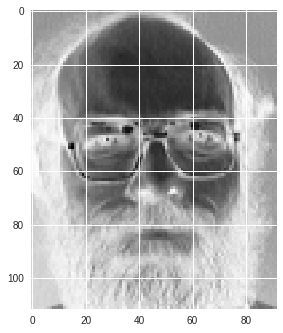

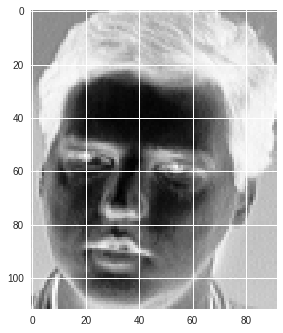

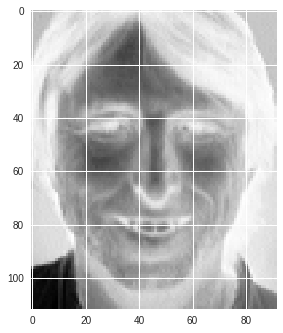

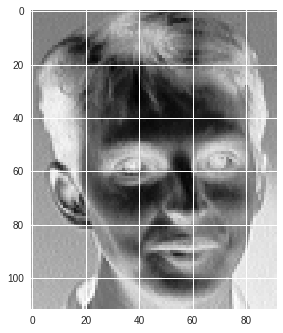

40


In [75]:
imgs = []
for i in range(40):
    plt.figure(i)                # the first figure
    imgs.append(X[10*i,:].reshape(112,92))
    plt.imshow(imgs[i])
    plt.show()
print(len(imgs))

### Performing PCA before to overcome LDA problems and enhancing the accuracy

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 140)

In [0]:
X_reduced = pca.fit_transform(X)

In [0]:
sum(pca.explained_variance_ratio_)

0.9219970180392919

In [0]:
len(X_reduced[0])

140

In [0]:
# Splitting the features
X_train = X_reduced[1::2]
X_test = X_reduced[::2]

# Splitting the labels 
y_train = y[1::2]
y_test = y[::2]

In [0]:
def classes_subsets(Data):
    subsets = []
    low = 0
    high = 5
    for i in range(len(Data)//5):
        
        subsets.append(Data[low:high])
        low += 5
        high += 5
    
    return subsets
        
# All subsets of classes in training set
D_train = classes_subsets(X_train)

### Class Means

In [0]:
def classes_means(Data):
    subsets = []
    low = 0
    high = 5
    mean = 0
    
    for i in range(len(Data)//5):
        
        # Calculating the mean for each class
        mean = np.apply_along_axis(np.mean, 0, X_train[low:high])
        subsets.append(mean)
        low += 5
        high += 5
        
    return subsets
        
    
# All subsets of classes in training set
train_means = classes_means(X_train)

In [0]:
# Mean over the whole population sample
sample_mean = np.apply_along_axis(np.mean, 0, X_train)

### Between classes scatter matrix

In [0]:
S_b = 0

for i in range(len(train_means)):

  S_b += 5 * ( (train_means[i] - sample_mean).reshape((-1, 1)) @ (train_means[i] - sample_mean).reshape((1, -1)) )

In [0]:
S_b.shape

(140, 140)

### Center class matrices

In [0]:
Z = []

for i in range(len(D_train)):
    
    # Subtracting data points from the mean
    Z.append(D_train[i] - train_means[i])

### Within class scatter matrix

In [0]:
S = Z[0].T @ Z[0]
for i in range(1, len(Z)):
    S += Z[i].T @ Z[i]

In [0]:
# Checking if the matrix is invertible
print(np.linalg.matrix_rank(S) == S.shape[0])

True


In [0]:
S_inverse = np.linalg.inv(S)

In [0]:
S_inverse.shape

(140, 140)

In [0]:
x = S_inverse @ S_b

In [0]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

check_symmetric(x)

False

In [0]:
eigen_values, eigen_vectors = np.linalg.eig(x)

In [0]:
eigen_vectors.shape

(140, 140)

### Shuffling the training set

In [0]:
np.random.seed(42)
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
x_shuffled = X_train[s]
y_shuffled = y_train[s]

### Sorting eigen values descendingly and taking corresponding 39 eigen vectors

In [0]:
idx = eigen_values.argsort()[::-1]   
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

In [0]:
U = eigen_vectors[:39].real
X_train_projected = x_shuffled @ U.T

print(U.shape)
print(x_shuffled.shape)
print(X_train_projected.shape)

(39, 140)
(200, 140)
(200, 39)


In [0]:
# Projecting test set to the reduced dimensions space
X_test_projected = X_test @ U.T

### Training KNN Model for odd k

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


k = [1, 3, 5, 7, 9, 11]
accuracy = []
for n_neigbor in k:
  
  knn = KNeighborsClassifier(n_neighbors = n_neigbor)
  knn.fit(X_train_projected, y_shuffled)
  
  y_pred = []

  for inst in X_test_projected:
    y_pred.append(knn.predict(inst.reshape((1, -1))))
    
  accuracy.append(accuracy_score(y_pred, y_test))

### Plotting K vs accuracy

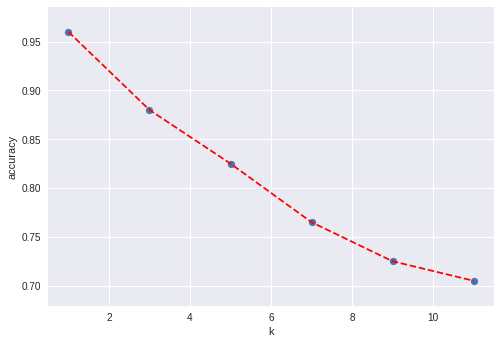

In [0]:
plt.scatter(k, accuracy)
plt.plot(k, accuracy, '--r')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

### Training the KNN with the best k

In [0]:
k_max_acc = accuracy.index(max(accuracy))
knn = KNeighborsClassifier(n_neighbors = k[k_max_acc])
knn.fit(X_train_projected, y_shuffled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [0]:
y_pred = []

for inst in X_test_projected:
  y_pred.append(knn.predict(inst.reshape((1, -1))))

### Test accuracy score of the model

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, y_test)*100

96.0

### Searching for the best n_components for the pre-processing step PCA

In [0]:
acc = []
for i in range(40, 200, 1):
  pca = PCA(n_components = i)
  X_reduced = pca.fit_transform(X)
  X_train = X_reduced[1::2]
  X_test = X_reduced[::2]

  y_train = y[1::2]
  y_test = y[::2]
  D_train = classes_subsets(X_train)
  train_means = classes_means(X_train)
  sample_mean = np.apply_along_axis(np.mean, 0, X_train)
  S_b = 0

  for i in range(len(train_means)):
    S_b += 5 * ( (train_means[i] - sample_mean).reshape((-1, 1)) @ (train_means[i] - sample_mean).reshape((1, -1)) )
    
  Z = []
  
  for i in range(len(D_train)):
      # Subtracting data points from the mean
      Z.append(D_train[i] - train_means[i])
  
  S = Z[0].T @ Z[0]
  for i in range(1, len(Z)):
    S += Z[i].T @ Z[i]
  
  if np.linalg.matrix_rank(S) == S.shape[0]:
    S_inverse = np.linalg.inv(S)
  else:
    S_inverse = np.linalg.pinv(S)
  
  x = S_inverse @ S_b
  
  if check_symmetric(x):
    eigen_values, eigen_vectors = np.linalg.eigh(x)
  else:
    eigen_values, eigen_vectors = np.linalg.eig(x)
    
  np.random.seed(42)
  s = np.arange(X_train.shape[0])
  np.random.shuffle(s)
  x_shuffled = X_train[s]
  y_shuffled = y_train[s]
  idx = eigen_values.argsort()[::-1]   
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:,idx]
  U = eigen_vectors[:39].real
  X_train_projected = x_shuffled @ U.T
  
  X_test_projected = X_test @ U.T
  
  knn = KNeighborsClassifier(n_neighbors = k[k_max_acc])
  knn.fit(X_train_projected, y_shuffled)
  
  y_pred = []

  for inst in X_test_projected:
    y_pred.append(knn.predict(inst.reshape((1, -1))))
    
  acc.append(accuracy_score(y_pred, y_test))

In [0]:
components = [i for i in range(40, 200, 1)]

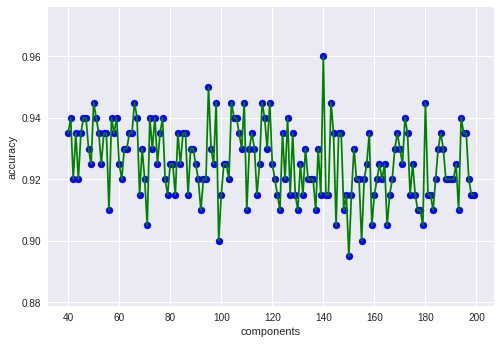

In [0]:
plt.scatter(components, acc, c='b')
plt.plot(components, acc, 'g')
plt.grid(True)
plt.xlabel('components')
plt.ylabel('accuracy')
plt.show()

## Train-Test Split 70-30

In [0]:
def split(X, y):
  
  low = 0
  high = 7

  data_train = []
  y_train = []
  data_test = []
  y_test = []

  for i in range(0, len(X), 10):
    # Train Data
    data_train.append(X[low:high, :])
    y_train.extend(y[low:high])

    # Test Data
    data_test.append(X[high:high+3, :])
    y_test.append(y[high:high+3])

    low += 10
    high += 10

  # Training Data
  data_train = np.array(data_train)
  data_train = np.vstack(data_train)
  
  y_train = np.array(y_train)
  y_train = np.hstack(y_train)

  # Testing Data
  data_test = np.array(data_test)
  data_test = np.vstack(data_test)
  
  y_test = np.array(y_test)
  y_test = np.hstack(y_test)
  
  
  return data_train, y_train, data_test, y_test

In [0]:
np.random.seed(42)

In [0]:
pca = PCA(n_components = 158)

X_reduced = pca.fit_transform(X)

X_train, y_train, X_test, y_test = split(X_reduced, y)

In [396]:
sum(pca.explained_variance_ratio_)

0.933091865982009

In [0]:
D_train = classes_subsets(X_train)
train_means = classes_means(X_train)
sample_mean = np.apply_along_axis(np.mean, 0, X_train)

In [0]:
S_b = 0

for i in range(len(train_means)):
  S_b += 5 * ( (train_means[i] - sample_mean).reshape((-1, 1)) @ (train_means[i] - sample_mean).reshape((1, -1)) )

In [0]:
Z = []

for i in range(len(D_train)):
    # Subtracting data points from the mean
    Z.append(D_train[i] - train_means[i])

In [0]:
S = Z[0].T @ Z[0]

for i in range(1, len(Z)):
  S += Z[i].T @ Z[i]

In [401]:
print(np.linalg.matrix_rank(S) == S.shape[0])

True


In [0]:
S_inverse = np.linalg.inv(S)

In [0]:
x = S_inverse @ S_b

In [404]:
check_symmetric(x)

False

In [0]:
eigen_values, eigen_vectors = np.linalg.eig(x)

In [0]:
idx = eigen_values.argsort()[::-1]   
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]
U = eigen_vectors[:39].real

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
x_shuffled = X_train[s]
y_shuffled = y_train[s]

X_train_projected = x_shuffled @ U.T

X_test_projected = X_test @ U.T

In [0]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_projected, y_shuffled)

y_pred = []

for inst in X_test_projected:
  y_pred.append(knn.predict(inst.reshape((1, -1))))

### Test accuracy score of the model

In [408]:
accuracy_score(y_pred, y_test)

0.9666666666666667

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


k = [1, 3, 5, 7, 9, 11]
accuracy = []
for n_neigbor in k:
  
  knn = KNeighborsClassifier(n_neighbors = n_neigbor)
  knn.fit(X_train_projected, y_shuffled)
  
  y_pred = []

  for inst in X_test_projected:
    y_pred.append(knn.predict(inst.reshape((1, -1))))
    
  accuracy.append(accuracy_score(y_pred, y_test))

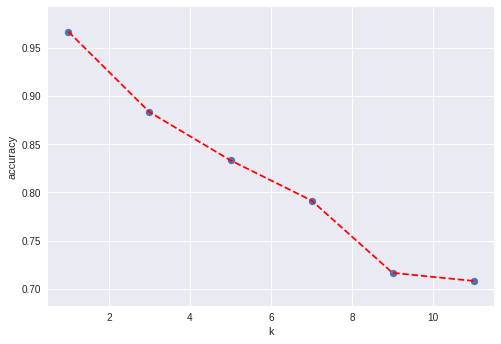

In [410]:
plt.scatter(k, accuracy)
plt.plot(k, accuracy, '--r')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

## PCA vs LDA

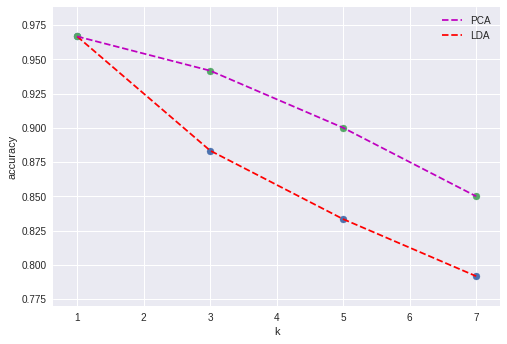

In [417]:
pca_acc = [0.9666667, 0.9416667, 0.9, 0.85]
k = [1, 3, 5, 7]
# Plotting LDA line
plt.scatter(k, accuracy[:4])
lda, = plt.plot(k, accuracy[:4], '--r')
# Plotting PCA line
plt.scatter(k, pca_acc)
pca, = plt.plot(k, pca_acc, '--m')
plt.legend([pca, lda],["PCA", "LDA"] )
plt.grid(True)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

# Faces vs Non-Faces

In [0]:
!unzip "bonus_Data.zip"

In [0]:
# convert image to sole vector
def img2vector(filename):
    imgVector = mpimg.imread(filename).flatten()
    return imgVector.astype(np.float)

# load image from diretion
def loadimage(dataSetDir):
    X = np.zeros((100, 10305))  # image size:112*92
    k = 0
    for i in range(1,41): #40 sample people
#             for j in range(1,11): #everyone has 10 different face
              filename = dataSetDir+'/'+str(i)+ '_result' +'.pgm'
              img = img2vector(filename)
              X[k,:10304] = img
              X[k,10304] = i
              k=k+1                    
    return X

In [427]:
X_non = loadimage(os.getcwd()+'/bonus_Data/rand_imgs_pgm')
y_non = X_non[:,10304]
X_non = X_non[:,:10304]
print(X_non.shape)
print(y_non.shape)

(100, 10304)
(100,)


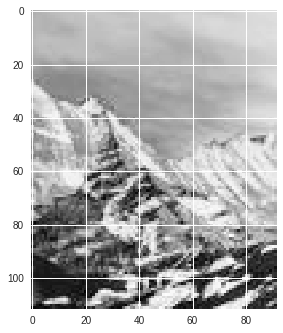

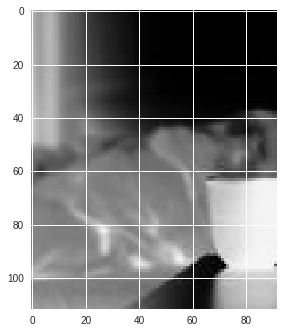

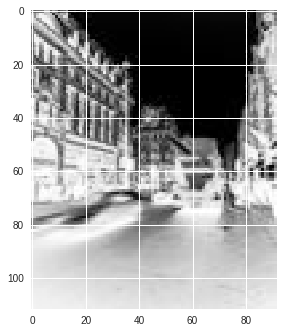

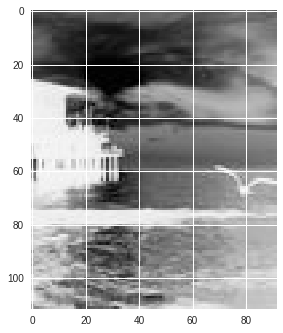

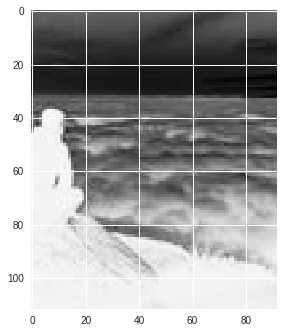

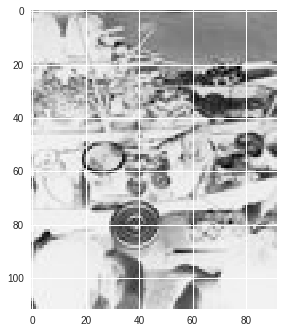

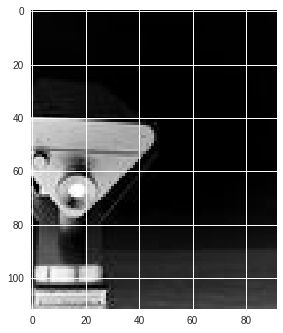

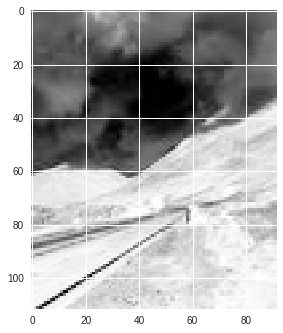

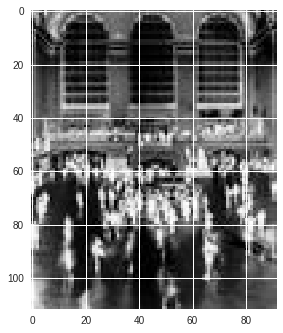

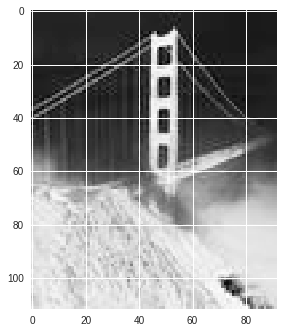

10


In [429]:
imgs = []
for i in range(10):
    plt.figure(i)
    imgs.append(X_non[i,:].reshape(112,92))
    plt.imshow(imgs[i])
    plt.show()
print(len(imgs))

In [0]:
faces_target = [0 for i in range(400)]
non_faces_target = [1 for i in range(100)]

In [0]:
pca = PCA(n_components = 100)
X_faces = pca.fit_transform(X)

In [0]:
pca = PCA(n_components = 100)
X_non = pca.fit_transform(X_non)

## Splitting Faces

In [0]:
# Splitting the features
X_train_faces = X_faces[1::2]
X_test_faces = X_faces[::2]

# Splitting the labels 
y_train_faces = faces_target[1::2]
y_test_faces = faces_target[::2]

## Splitting Non-Faces

In [0]:
# Splitting the features
X_train_non = X_non[1::2]
X_test_non = X_non[::2]

# Splitting the labels 
y_train_non = non_faces_target[1::2]
y_test_non = non_faces_target[::2]

In [0]:
mu_faces = np.apply_along_axis(np.mean, 0, X_train_faces)

mu_non = np.apply_along_axis(np.mean, 0, X_train_non)

In [0]:
# mean difference
diff = mu_faces - mu_non

# between-class scatter matrix
B = diff.reshape((-1, 1)) @ diff.reshape((1, -1))

In [0]:
Z_faces = X_train_faces - mu_faces.T

Z_non = X_train_non - mu_non.T

In [0]:
S_faces = Z_faces.T @ Z_faces

S_non = Z_non.T @ Z_non

In [0]:
S = S_faces + S_non

In [474]:
print(np.linalg.matrix_rank(S) == S.shape[1])

True


In [0]:
S_inverse = np.linalg.inv(S)

In [0]:
x = S_inverse @ B 

In [477]:
check_symmetric(x)

False

In [0]:
eigen_values, eigen_vectors = np.linalg.eig(x)

In [0]:
idx = eigen_values.argsort()[::-1]   
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

In [0]:
X_train_all = np.concatenate((X_train_faces, X_train_non))
X_test_all = np.concatenate((X_test_faces, X_test_non))
labels_train = y_train_faces + y_train_non
labels_test = y_test_faces + y_test_non

In [0]:
U = eigen_vectors[:39].real
X_train_projected = X_train_all @ U.T

In [0]:
X_test_projected = X_test_all @ U.T

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


k = [1, 3, 5, 7, 9, 11]
accuracy = []
for n_neigbor in k:
  
  knn = KNeighborsClassifier(n_neighbors = n_neigbor)
  knn.fit(X_train_projected, labels_train)
  
  y_pred = []

  for inst in X_test_projected:
    y_pred.append(knn.predict(inst.reshape((1, -1))))
    
  accuracy.append(accuracy_score(y_pred, labels_test))

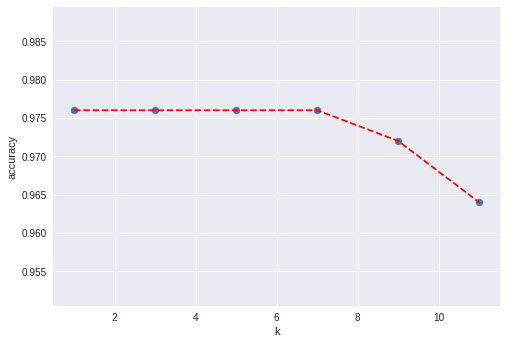

In [498]:
plt.scatter(k, accuracy)
plt.plot(k, accuracy, '--r')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

In [490]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_projected, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [0]:
y_pred = []

for inst in X_test_projected:
  y_pred.append(knn.predict(inst.reshape((1, -1))))

In [495]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, labels_test)*100

97.6